# 05 - Retraining

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import time

import joblib
import json
import pickle

In [3]:
import sys
sys.path.append('../')

import src

In [4]:
plt.style.use('fivethirtyeight')
pd.set_option('precision', 4)

## Load model

In [5]:
with open('../deploy/columns.json') as fh:
    columns = json.load(fh)

with open('../deploy/dtypes.pickle', 'rb') as fh:
    dtypes = pickle.load(fh)

pipeline = joblib.load('../deploy/pipeline.pickle')

## Load database data

In [6]:
df_heroku = src.loader.load_heroku_csv(columns, dtypes)

In [7]:
df_heroku.head(2)

,type,date,operation,lat,long,sex,age,ethnicity_officer,legislation,search_target,station,predicted_outcome,success
observation_id,,,,,,,,,,,,,
cf46ed6e-e6bb-4bc9-959d-ef2e5a8162a0,Person search,2020-01-01 01:45:00+00:00,False,NaN,NaN,Male,18-24,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,nottinghamshire,True,False
3601e51b-f40a-4466-b884-d9284497462c,Person search,2020-01-01 02:53:14+00:00,NaN,NaN,NaN,Male,18-24,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,city-of-london,True,False


In [8]:
df_customer =  pd.read_csv('../data/X_test_1.csv')\
                    .set_index('observation_id')\
                    .drop(columns=['Self-defined ethnicity'])
df_customer.columns = columns
df_customer = df_customer.astype(dtypes)
df_customer['predicted_outcome'] = src.evaluate.authorise_search(pipeline, df_customer)
df_customer = df_customer.join(pd.read_csv('../data/y_test_1.csv')\
                                  .set_index('observation_id')\
                                  .rename(columns={'0': 'success'}))

In [9]:
df_customer.head(2)

,type,date,operation,lat,long,sex,age,ethnicity_officer,legislation,search_target,station,predicted_outcome,success
observation_id,,,,,,,,,,,,,
3d931c84-94d3-4a14-869c-b10fef26e9ad,Person search,2020-01-01 00:56:00+00:00,False,NaN,NaN,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,nottinghamshire,True,False
cf46ed6e-e6bb-4bc9-959d-ef2e5a8162a0,Person search,2020-01-01 01:45:00+00:00,False,NaN,NaN,Male,18-24,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,nottinghamshire,True,False


## Analysis

### Data Profile

In [11]:
profile = pp.ProfileReport(df_customer, title='Live Data Profiling Report', explorative=False, minimal=False, pool_size=0, progress_bar=True)
profile.to_file('../reports/profiling/live_profile.html')

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/pandas_profiling/model/correlations.py:139: UserWarning: There was an attempt to calculate the phi_k correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"phi_k": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'No data; `observed` has size 0.')
  (include the error message: '{error}')"""


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Analyse Results

In [12]:
from sklearn.metrics import precision_score, confusion_matrix

In [13]:
# set up
df_results = pd.DataFrame(index=['Search precision',
                                 'Maximum discrimination within station between ethnicity-gender-subgroup',
                                 'Maximum precision discrepancy between stations overall',
                                 'Maximum discrimination between ethnicity-gender-subgroups'],
                          columns=['Model', 'Benchmark', 'Target'])

# pipeline
include = df_customer['success'].notna()
authorised = df_customer.loc[include, 'predicted_outcome'].astype(bool)
success = df_customer.loc[include, 'success'].astype(bool)
X = df_customer.loc[include, columns]
df_results.iat[0, 0] = precision_score(success, authorised)
df_results.iat[1, 0] = src.evaluate.within_station_discrepancy(authorised, success, X).max()
df_results.iat[2, 0] = src.evaluate.across_station_discrepancy(authorised, success, X)
df_results.iat[3, 0] = src.evaluate.across_subgroup_discrepancy(authorised, success, X)

# evaluate benchmark
df_results.iat[0, 1] = precision_score(success, np.ones(success.shape))
df_results.iat[1, 1] = src.evaluate.within_station_discrepancy(np.ones(success.shape), success, X).max()
df_results.iat[2, 1] = src.evaluate.across_station_discrepancy(np.ones(success.shape), success, X)
df_results.iat[3, 1] = src.evaluate.across_subgroup_discrepancy(np.ones(success.shape), success, X)

# targets
df_results.iat[0, 2] = '-'
df_results.iat[1, 2] = 0.05
df_results.iat[2, 2] = 0.1
df_results.iat[3, 2] = 0.05

df_results

,Model,Benchmark,Target
Search precision,0.2915,0.2782,-
Maximum discrimination within station between ethnicity-gender-subgroup,0.117,0.1123,0.05
Maximum precision discrepancy between stations overall,0.3573,0.397,0.1
Maximum discrimination between ethnicity-gender-subgroups,0.113,0.1152,0.05


In [14]:
pd.DataFrame(confusion_matrix(success, authorised),
             index=pd.MultiIndex.from_product([['True outcome'], ['no succes', 'success']]),
             columns=pd.MultiIndex.from_product([['Predicted outcome'], ['no succes', 'success']]),
            )

Predicted outcome        
                               no succes success
True outcome no succes               242    2645
             success                  25    1088

##### Fairness

In [15]:
src.evaluate.calculate_subgroup_precisions(authorised, success, X, grouping=['ethnicity', 'gender']).unstack()

gender,Female,Male
ethnicity,,
Asian,NaN,0.2202
Black,NaN,0.2461
Mixed,NaN,0.2148
Other,NaN,0.2317
White,0.3152,0.3278


In [16]:
src.evaluate.calculate_subgroup_precisions(np.ones(success.shape), success, X, grouping=['ethnicity', 'gender']).unstack()

gender,Female,Male
ethnicity,,
Asian,NaN,0.2114
Black,NaN,0.2408
Mixed,NaN,0.1988
Other,NaN,0.2299
White,0.314,0.3093


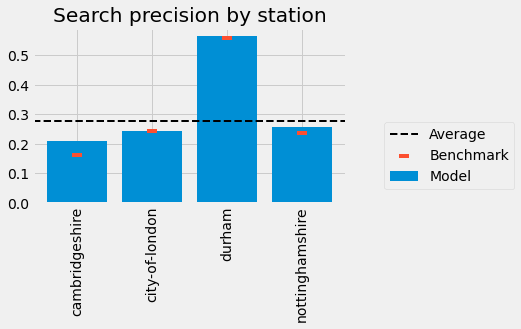

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))

station_precisions = src.evaluate.calculate_subgroup_precisions(authorised, success, X, grouping=['station']).dropna()
ax.set_title('Search precision by station')
ax.bar(x=np.arange(0, len(station_precisions), 1), height=station_precisions, label='Model')
ax.scatter(x=np.arange(0, len(station_precisions), 1), y=src.evaluate.calculate_subgroup_precisions(np.ones(success.shape), success, X, grouping=['station']).dropna(), zorder=10, label='Benchmark', marker='_', s=100)
ax.axhline(precision_score(success, np.ones(success.shape)), linewidth=2, linestyle='--', c='k', label='Average')
ax.set_xticks(np.arange(0, len(station_precisions), 1))
ax.set_xticklabels(station_precisions.index, rotation=90)
ax.legend(bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

fig.savefig('../reports/figures/live_stations_precision.jpg', dpi=300, bbox_inches='tight')

## Improve Model
First, we reduce bias by explicitly correcting for group means.
(replace src.evaluate.authorise_search function)

Then, add ethnicity feature to pipeline.

Finally, retrain with full dataset, overweighting recent observations.

### Prepare re-training data

In [21]:
df = pd.read_pickle('../data/training.pickle')

In [22]:
df.head(1)

,type,date,operation,lat,long,sex,age,ethnicity_self,ethnicity_officer,legislation,search_target,outcome,found_target,stripped,station,offense,success
observation_id,,,,,,,,,,,,,,,,,
d62c9e35-6293-45fc-aab6-706bdac1601e,Person search,2017-12-01 00:00:00+00:00,False,50.9234,-0.4611,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Offender given drugs possession warning,False,False,sussex,True,False


In [23]:
df = df[columns + ['success']]
for i in range(2): # overweight recent data
    df = df.append(df_customer[columns + ['success']])

#### Drop metropolitan station from dataset

In [24]:
df = df[df.station!='metropolitan']
df.shape

(317317, 12)

#### Select relevant columns

Requests will have the following format:
```
["observation_id": <string>,
 "Type": <string>,
 "Date": <string>,
 "Part of a policing operation": <boolean>,
 "Latitude": <float>,
 "Longitude": <float>,
 "Gender": <string>,
 "Age range": <string>,
 "Officer-defined ethnicity": <string>,
 "Legislation": <string>,
 "Object of search": <string>,
 "station": <string>]
 '''


In [25]:
supplied_columns = ['type', 'date', 'operation', 'lat', 'long', 'sex', 'age', 'ethnicity_officer', 'legislation', 'search_target', 'station']

In [26]:
X = df[supplied_columns]
y = df.success.values

### Adapt pipeline

In [27]:
from sklearn.preprocessing import OneHotEncoder

In [28]:
categoricals = ['type', 'sex', 'age', 'search_target', 'station', 'ethnicity_officer']
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
pipeline['preprocess'].transformer_list[0][1].transformers[2] = ('cat_encoder', oh_encoder, categoricals)

#### Train-Validation Split

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, stratify=X[['station']], shuffle=True)

#### Fit

In [31]:
pipeline_ = pipeline.fit(X, y)

/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Evaluation

In [38]:
# set up
df_results = pd.DataFrame(index=['Search precision',
                                 'Maximum discrimination within station between ethnicity-gender-subgroup',
                                 'Maximum precision discrepancy between stations overall',
                                 'Maximum discrimination between ethnicity-gender-subgroups'],
                          columns=['Model', 'Benchmark', 'Target'])

# pipeline
authorised = src.evaluate.authorise_search(pipeline_, X, bias_correction=True).astype(bool)

df_results.iat[0, 0] = precision_score(y, authorised)
df_results.iat[1, 0] = src.evaluate.within_station_discrepancy(authorised, y, X).max()
df_results.iat[2, 0] = src.evaluate.across_station_discrepancy(authorised, y, X)
df_results.iat[3, 0] = src.evaluate.across_subgroup_discrepancy(authorised, y, X)

# evaluate benchmark
df_results.iat[0, 1] = precision_score(y, np.ones(y.shape))
df_results.iat[1, 1] = src.evaluate.within_station_discrepancy(np.ones(y.shape), y, X).max()
df_results.iat[2, 1] = src.evaluate.across_station_discrepancy(np.ones(y.shape), y, X)
df_results.iat[3, 1] = src.evaluate.across_subgroup_discrepancy(np.ones(y.shape), y, X)

# targets
df_results.iat[0, 2] = '-'
df_results.iat[1, 2] = 0.05
df_results.iat[2, 2] = 0.1
df_results.iat[3, 2] = 0.05

df_results

,Model,Benchmark,Target
Search precision,0.2399,0.2033,-
Maximum discrimination within station between ethnicity-gender-subgroup,0.2582,0.24,0.05
Maximum precision discrepancy between stations overall,0.4133,0.4111,0.1
Maximum discrimination between ethnicity-gender-subgroups,0.05469,0.03871,0.05


In [35]:
# set up
df_results = pd.DataFrame(index=['Search precision',
                                 'Maximum discrimination within station between ethnicity-gender-subgroup',
                                 'Maximum precision discrepancy between stations overall',
                                 'Maximum discrimination between ethnicity-gender-subgroups'],
                          columns=['Model', 'Benchmark', 'Target'])

# pipeline
authorised = src.evaluate.authorise_search(pipeline_, X_train, bias_correction=True).astype(bool)

df_results.iat[0, 0] = precision_score(y_train, authorised)
df_results.iat[1, 0] = src.evaluate.within_station_discrepancy(authorised, y_train, X_train).max()
df_results.iat[2, 0] = src.evaluate.across_station_discrepancy(authorised, y_train, X_train)
df_results.iat[3, 0] = src.evaluate.across_subgroup_discrepancy(authorised, y_train, X_train)

# evaluate benchmark
df_results.iat[0, 1] = precision_score(y_train, np.ones(y_train.shape))
df_results.iat[1, 1] = src.evaluate.within_station_discrepancy(np.ones(y_train.shape), y_train, X_train).max()
df_results.iat[2, 1] = src.evaluate.across_station_discrepancy(np.ones(y_train.shape), y_train, X_train)
df_results.iat[3, 1] = src.evaluate.across_subgroup_discrepancy(np.ones(y_train.shape), y_train, X_train)

# targets
df_results.iat[0, 2] = '-'
df_results.iat[1, 2] = 0.05
df_results.iat[2, 2] = 0.1
df_results.iat[3, 2] = 0.05

df_results

,Model,Benchmark,Target
Search precision,0.2403,0.2037,-
Maximum discrimination within station between ethnicity-gender-subgroup,0.2776,0.2616,0.05
Maximum precision discrepancy between stations overall,0.4184,0.4162,0.1
Maximum discrimination between ethnicity-gender-subgroups,0.04439,0.03297,0.05


In [36]:
# set up
df_results = pd.DataFrame(index=['Search precision',
                                 'Maximum discrimination within station between ethnicity-gender-subgroup',
                                 'Maximum precision discrepancy between stations overall',
                                 'Maximum discrimination between ethnicity-gender-subgroups'],
                          columns=['Model', 'Benchmark', 'Target'])

# pipeline
authorised = src.evaluate.authorise_search(pipeline_, X_val, bias_correction=True).astype(bool)

df_results.iat[0, 0] = precision_score(y_val, authorised)
df_results.iat[1, 0] = src.evaluate.within_station_discrepancy(authorised, y_val, X_val).max()
df_results.iat[2, 0] = src.evaluate.across_station_discrepancy(authorised, y_val, X_val)
df_results.iat[3, 0] = src.evaluate.across_subgroup_discrepancy(authorised, y_val, X_val)

# evaluate benchmark
df_results.iat[0, 1] = precision_score(y_val, np.ones(y_val.shape))
df_results.iat[1, 1] = src.evaluate.within_station_discrepancy(np.ones(y_val.shape), y_val, X_val).max()
df_results.iat[2, 1] = src.evaluate.across_station_discrepancy(np.ones(y_val.shape), y_val, X_val)
df_results.iat[3, 1] = src.evaluate.across_subgroup_discrepancy(np.ones(y_val.shape), y_val, X_val)

# targets
df_results.iat[0, 2] = '-'
df_results.iat[1, 2] = 0.05
df_results.iat[2, 2] = 0.1
df_results.iat[3, 2] = 0.05

df_results

,Model,Benchmark,Target
Search precision,0.2389,0.2023,-
Maximum discrimination within station between ethnicity-gender-subgroup,0.2343,0.2434,0.05
Maximum precision discrepancy between stations overall,0.243,0.3995,0.1
Maximum discrimination between ethnicity-gender-subgroups,0.1183,0.09418,0.05


In [39]:
pd.DataFrame(confusion_matrix(y, authorised),
             index=pd.MultiIndex.from_product([['True outcome'], ['no succes', 'success']]),
             columns=pd.MultiIndex.from_product([['Predicted outcome'], ['no succes', 'success']]),
            )

Predicted outcome        
                               no succes success
True outcome no succes             61085  191720
             success                4003   60509

##### Fairness

In [40]:
src.evaluate.calculate_subgroup_precisions(authorised, y, X, grouping=['ethnicity', 'gender']).unstack()

gender,Female,Male
ethnicity,,
Asian,0.2084,0.2336
Black,0.2126,0.2402
Mixed,0.2033,0.2427
Other,0.2580,0.2433
White,0.2074,0.2453


In [41]:
src.evaluate.calculate_subgroup_precisions(np.ones(y.shape), y, X, grouping=['ethnicity', 'gender']).unstack()

gender,Female,Male
ethnicity,,
Asian,0.1887,0.2011
Black,0.1964,0.2089
Mixed,0.1884,0.2097
Other,0.2204,0.2131
White,0.1817,0.2053


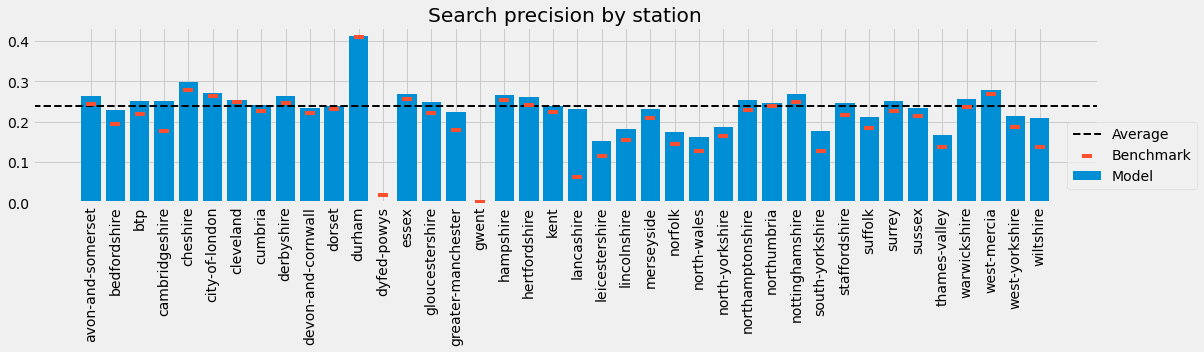

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(17,3))

station_precisions = src.evaluate.calculate_subgroup_precisions(authorised, y, X, grouping=['station']).dropna()
ax.set_title('Search precision by station')
ax.bar(x=np.arange(0, len(station_precisions), 1), height=station_precisions, label='Model')
ax.scatter(x=np.arange(0, len(station_precisions), 1), y=src.evaluate.calculate_subgroup_precisions(np.ones(y.shape), y, X, grouping=['station'])[station_precisions.index], zorder=10, label='Benchmark', marker='_', s=100)
ax.axhline(precision_score(y, authorised), linewidth=2, linestyle='--', c='k', label='Average')
ax.set_xticks(np.arange(0, len(station_precisions), 1))
ax.set_xticklabels(station_precisions.index, rotation=90)
ax.legend(bbox_to_anchor=(1.1, 0.5), ncol=1)
plt.show()

fig.savefig('../reports/figures/stations_precision_retrain.jpg', dpi=300, bbox_inches='tight')

### Serialise

In [43]:
# serialise
joblib.dump(pipeline_, '../deploy/pipeline.pickle')

['../deploy/pipeline.pickle']